Mask out-of-source-domain / unmapped grid cells of the target grid
================

## for the nearest-neighbour method ('nearest_s2d') of xESMF
### Example of a regional curvilinear grid

### Basic Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
print("Using xESMF in version %s" % xe.__version__)

import warnings
warnings.simplefilter("ignore") 
#with warnings.catch_warnings():
#        warnings.simplefilter("ignore")

xr.set_options(display_style='html');

Using xESMF in version 0.5.3.dev11+gcb46501


### Load the dataset

In [2]:
pool_path="/mnt/lustre01/work/kd0956/CORDEX/data/cordex"
ds_path="output/EUR-22/GERICS/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/tas/v20191029"
ifile="tas_EUR-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_207101-208012.nc"
ds_in = xr.open_dataset(pool_path+"/"+ds_path+"/"+ifile)

### Plot the grid

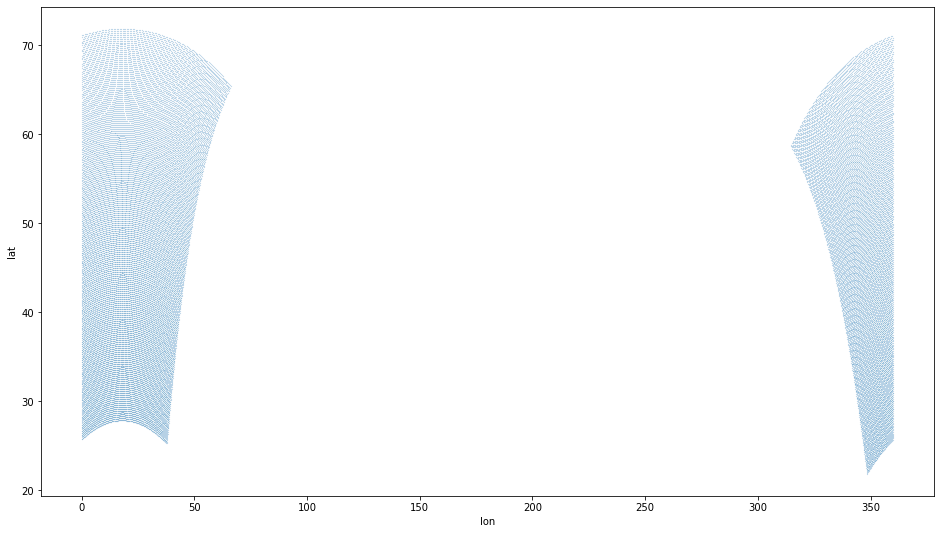

In [3]:
# plot grid
plt.figure(figsize=(16,9))
plt.scatter(ds_in['lon'], ds_in['lat'], s=0.01)  
plt.xlabel('lon');
plt.ylabel('lat');

### Plot the data

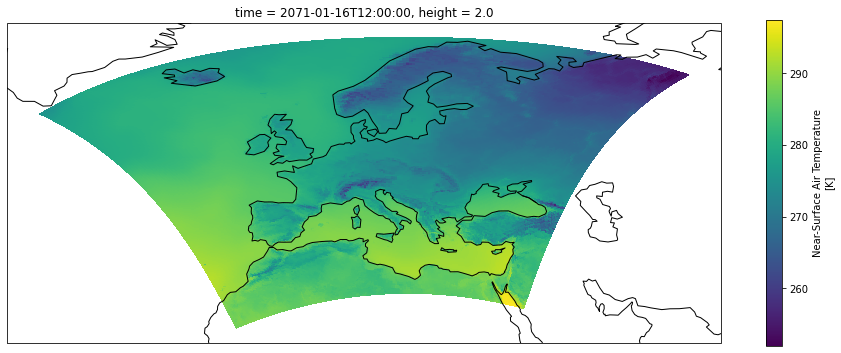

In [4]:
# Using matplotlib / cartopy / xarray
plt.figure(figsize=(16,6));
ax = plt.axes(projection=ccrs.PlateCarree());
ds_in.tas.isel(time=0).plot.pcolormesh(ax=ax, x='lon', y='lat', shading='flat');
ax.coastlines();

### Set up the destination grid

In [5]:
# Specify a global 1 deg grid
ds_out = xe.util.grid_global(1,1) # global 5 degree grid

### Calculate the distances

In [6]:
from scipy.spatial import cKDTree

def lon_lat_to_cartesian(lon, lat, R = 6371000):
    """
    # Taken from FESOM/pyfesom - https://github.com/FESOM/pyfesom/blob/master/pyfesom/regriding.py
    
    Calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    Parameters
    ----------
    lon : 1d array
        longitudes
    lat : 1d array
        latitudes
    R   : float
        radius of the sphere
    Returns
    -------
    x,y,z : 1d arrays
        cartesian coordinates
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x =  R * np.cos(lat_r) * np.cos(lon_r)
    y =  R * np.cos(lat_r) * np.sin(lon_r)
    z =  R * np.sin(lat_r)
    return x,y,z

def create_indexes_and_distances(lon_in, lat_in, lon_out, lat_out, n_jobs=2,):
    '''
    # Adapted from FESOM/pyfesom - https://github.com/FESOM/pyfesom/blob/master/pyfesom/regriding.py
    
    Creates KDTree object and queries it for indexes of points in source grid that are closest to the
    points of the target grid. Also returns distances between the selected original points and target points
    as well as the average spacing of the source grid points.
 
    Parameters
    ----------
    lon_in/lat_in : array
        2d arrays with source grid values.
    lon_out/lat_out : array
        2d arrays with target grid values.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors. 
    inds : ndarray of ints
        The locations of the neighbors in data.  
    approx_res: float
        Approximate grid_spacing
    '''
   
    if len(lon_in.shape)==1:
        lon_in, lat_in = np.meshgrid(lon_in, lat_in)
    if len(lon_out.shape)==1:
        lon_out, lat_out = np.meshgrid(lon_out, lat_out)
    
    xs, ys, zs = lon_lat_to_cartesian(lon_in.flatten(), lat_in.flatten())
    xt, yt, zt = lon_lat_to_cartesian(lon_out.flatten(), lat_out.flatten()) 
    
    # Calculate shortest distances between destination and source grid points
    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k = 1, n_jobs=n_jobs)
    
    # Calculate average spacing of source grid points
    approx_res = np.average(tree.query(list(zip(xs, ys, zs)), k = 2, n_jobs=n_jobs)[0][:, 1])

    return distances, inds, approx_res

In [7]:
# Calculate the distances to the nearest source cells
dist,ind,res = create_indexes_and_distances(ds_in.lon.values,
                                            ds_in.lat.values,
                                            ds_out.lon.values,
                                            ds_out.lat.values)

### Create output mask to mask out-of-source-domain / unmapped grid cells of the target grid

In [8]:
mask=np.where(dist>=res*2, False, True).reshape(180,360)

ds_out['mask']=xr.DataArray(data=mask, dims=["lat", "lon"])

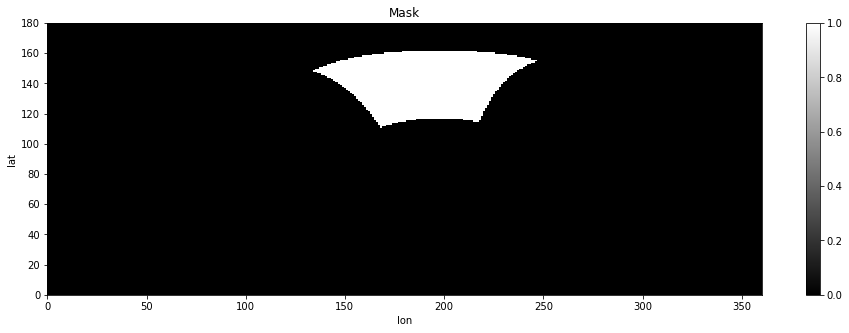

In [9]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(16,5))
im=axes.pcolormesh(mask, cmap="binary_r")
fig.colorbar(im, ax=axes)
axes.set_xlabel('lon');
axes.set_ylabel('lat');
axes.set_title('Mask');

### Calculate the regridding weights

In [10]:
# Create regridding weights - add_nans_to_weights is applied by default as an output mask is specified
def regrid(ds_in, ds_out, method):
    """Convenience function for calculating regridding weights"""
    return xe.Regridder(ds_in, ds_out, method)

# Just looking at nearest_s2d
# method_list = ['bilinear','nearest_s2d', 'conservative', 'conservative_normed', 'patch']
method_list = ['nearest_s2d']

regridder={}
for method in method_list:
    print()
    %time regridder[method]=regrid(ds_in, ds_out, method)
    print(regridder[method])


CPU times: user 279 ms, sys: 35 ms, total: 314 ms
Wall time: 313 ms
xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_201x225_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (201, 225) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False


### Perform the regridding

In [11]:
# Perform regridding
for method in method_list:
    ds_out["tas_"+method]=regridder[method](ds_in.tas)

### Plot regridded data

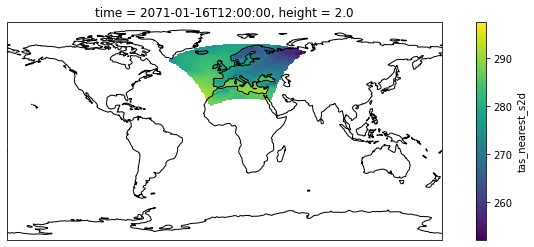

In [12]:
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out["tas_nearest_s2d"].isel(time=0).plot.pcolormesh(ax=ax, x='lon', y='lat');
ax.coastlines();